In [38]:
from lora.compress.gregodec import GreGoDec
from lora.compress.tsvd import TSVD
import torch
import torch.nn as nn
from transformers import RobertaModel

import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'

from lora.models.roberta_scratch import get_model
from omegaconf import OmegaConf
from transformers import RobertaTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import scipy as scp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch
import torch.nn as nn
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
class RobertaSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        
        self.key = nn.Linear(config.hidden_size, self.all_head_size)

        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


In [3]:
# load original model
model = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# prepare the validation dataset
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# def get_embeddings(model, dataloader, device):
#     model.eval()
#     progress = tqdm(enumerate(dataloader), total=len(dataloader))
#     embeddings = []
#     with torch.no_grad():
#         for i, data in progress:
#             ids = data["input_ids"].long().to(device)
#             token_type_ids = data["token_type_ids"].long().to(device)
#             masks = data["attention_mask"].long().to(device)
#             targets = data["label"].long().to(device)

#             outputs = model(ids, masks, token_type_ids)
#             embeddings.append(
#                 outputs[0][:, 0, :].detach().cpu().numpy()
#             )

#             progress.set_description(f"[{i + 1}/{len(dataloader)}] ")
#     return np.concatenate(embeddings)

def get_embeddings(model, data, device):
    model.eval()
    ids = data["input_ids"].long().to(device)
    token_type_ids = data["token_type_ids"].long().to(device)
    masks = data["attention_mask"].long().to(device)
    outputs = model(ids, masks, token_type_ids)
    embeddings = outputs[0][:, 0, :]
    return embeddings.detach().cpu().numpy()

def compute_distance_matrix(x):
    dist = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            dist[i, j] = np.linalg.norm(x[i] - x[j], ord=2)
    return dist

def get_latent_embeddings(x, seed=1996):
    dist = compute_distance_matrix(x)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
    return mds.fit_transform(dist)

def get_approx_matrix(W, target_rank, type, return_approx=True):
    if type == 'gregodec':
        if target_rank <= 10:
            k = 2
        if target_rank <= 100:
            k = 10
        else: 
            k = 100
        U, V, S, _ = GreGoDec(
            D = W,
            rank = target_rank,
            tau = 0.001,
            tol = 0.001, 
            power = 100,
            k = k
        ).fit()
        if return_approx:
            return U @ V + S
        else:
            return U, V, S
    elif type == 'tsvd':
        U, V = TSVD(
            D=W,
            rank=target_rank
        ).fit()
        if return_approx:
            return U @ V
        else:
            return U, V
    else:
        raise NotImplementedError

    
def get_approx_model(model, target_rank, type):
    approx_model = deepcopy(model)
    progress = tqdm(range(model.config.num_hidden_layers))
    for i in progress:
        W = approx_model.encoder.layer[i].attention.self.query.weight.cpu().detach().numpy()
        What = get_approx_matrix(W, target_rank=target_rank, type=type)
        approx_model.encoder.layer[i].attention.self.query.weight.data = torch.from_numpy(What).float()

        W = approx_model.encoder.layer[i].attention.self.key.weight.cpu().detach().numpy()
        What = get_approx_matrix(W, target_rank=target_rank, type=type)
        approx_model.encoder.layer[i].attention.self.key.weight.data = torch.from_numpy(What).float()

        W = approx_model.encoder.layer[i].attention.self.value.weight.cpu().detach().numpy()
        What = get_approx_matrix(W, target_rank=target_rank, type=type)
        approx_model.encoder.layer[i].attention.self.value.weight.data = torch.from_numpy(What).float()
    return approx_model

In [27]:
# get true model embeddings
model.to(device)
embeddings = get_embeddings(model, dataset["validation"][:10], device)
true_latent_embeddings = get_latent_embeddings(embeddings)

In [29]:
# get compressed model embeddings
rank_list = [10, 50, 100, 500]
approx_latent_embeddings = [[], []]
type_list = ['tsvd', 'gregodec']
for rank in rank_list:
    print(f"computing for rank: {rank}")
    for i, type in enumerate(type_list):
        print(type)
        approx_model = get_approx_model(model, target_rank=rank, type=type)
        approx_model.to(device)
        embeddings = get_embeddings(approx_model, dataset["validation"][:10], device)
        approx_latent_embeddings[i].append(
            get_latent_embeddings(embeddings)
        )

computing for rank: 10
tsvd


100%|██████████| 12/12 [00:00<00:00, 14.29it/s]


gregodec


100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


computing for rank: 50
tsvd


100%|██████████| 12/12 [00:18<00:00,  1.54s/it]


gregodec


100%|██████████| 12/12 [00:58<00:00,  4.86s/it]


computing for rank: 100
tsvd


100%|██████████| 12/12 [00:28<00:00,  2.37s/it]


gregodec


100%|██████████| 12/12 [05:42<00:00, 28.56s/it]


computing for rank: 500
tsvd


100%|██████████| 12/12 [18:17<00:00, 91.50s/it]


gregodec


100%|██████████| 12/12 [31:10<00:00, 155.88s/it] 


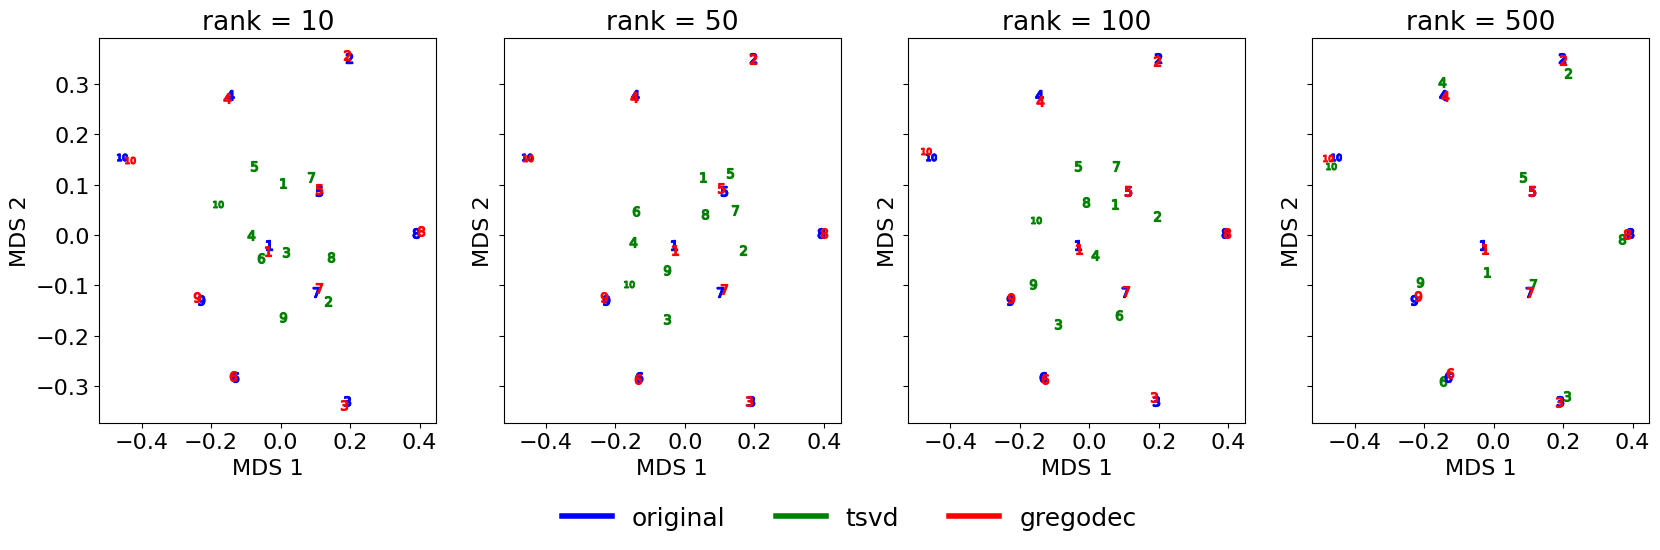

In [42]:
fig, axes = plt.subplots(1, len(rank_list), figsize=(5*len(rank_list), 5), sharex=True, sharey=True)
colors = ['g', 'r']
for j, type in enumerate(type_list):
    for k, rank in enumerate(rank_list):
        ax = axes.ravel()[k]
        # ax = axes
        d1, d2, _ = scp.spatial.procrustes(true_latent_embeddings, approx_latent_embeddings[j][k])
        for i, x in enumerate(d1):
            c = "b"
            ax.scatter(x[0], x[1], marker=f"${str(i+1)}$", c=c, s=50)
        for i, x in enumerate(d2):
            c = "r"
            ax.scatter(x[0], x[1], marker=f"${str(i+1)}$", c=colors[j], s=50)
        ax.set_title(f"rank = {rank}")
        ax.set_xlabel("MDS 1")
        ax.set_ylabel("MDS 2")

custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4)]
fig.legend(custom_lines, ["original"] + type_list, ncols=3, loc=8, bbox_to_anchor=(0.5, -0.15), fontsize=18, frameon=False)
plt.show()

In [43]:
fig.savefig("rank-vs-embed.pdf", bbox_inches='tight')

Text(0, 0.5, 'average distance')

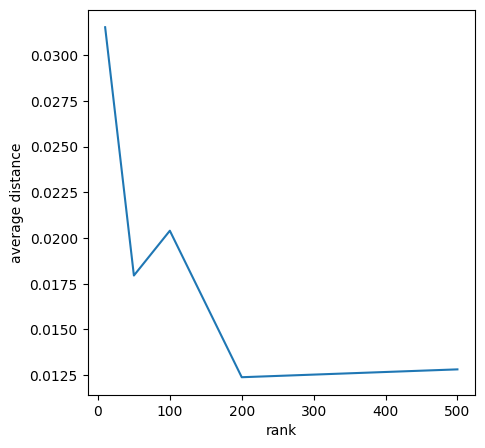

In [14]:
# optional
mean_dist_list = []
for i, rank in enumerate(rank_list):
    mean_dist_list.append(
        np.mean(
            np.linalg.norm(true_latent_embeddings - approx_latent_embeddings[i], ord=2, axis=1)
        )
    )

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rank_list, mean_dist_list)
ax.set_xlabel("rank")
ax.set_ylabel("average distance")